Here we will bw using MTCNN. This method gives the most accurate when compared to Haar cascade. It works for faces having various orientations in images and can detect faces across various scales. It can even handle occlusions. It doesn’t hold any major drawback as such but is comparatively slower than Haar cascade method.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pip install mtcnn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.7 MB/s eta 0:00:00


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os

1/1 [==============================] - 0s 127ms/step


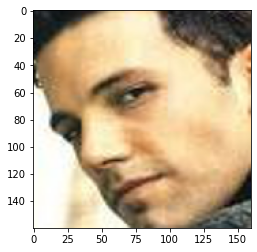

(160, 160, 3)


In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array
# load the photo and extract the face

pixels = extract_face('/content/gdrive/MyDrive/Sports-celebrity images/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)


In [6]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


In [7]:
# load train dataset
trainX, trainy = load_dataset('/content/gdrive/MyDrive/Sports-celebrity images/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/gdrive/MyDrive/Sports-celebrity images/data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 140ms/step
loaded 19 sample for class: madonna
1/1 [==============================] - 0s 153ms/step
loaded 14 sample for class: ben_afflek
1/1 [==============================] - 0s 144ms/step
loaded 17 sample for class: elton_john
1/1 [==============================] - 0s 146ms/step
loaded 22 sample for class: mindy_kaling
1/1 [==============================] - 1s 878ms/step
loaded 21 sample for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
1/1 [==============================] - 0s 136ms/step
loaded 5 sample for class: ben_afflek
1/1 [==============================] - 0s 143ms/step
loaded 5 sample for class: madonna
1/1 [==============================] - 0s 140ms/step
loaded 5 sample for class: elton_john
1/1 [==============================] - 0s 137ms/step
loaded 5 sample for class: jerry_seinfeld
1/1 [==============================] - 0s 146ms/step
loaded 5 sample for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [8]:
# load the face dataset
data = np.load('/content/gdrive/MyDrive/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [12]:
pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=e3c4d45fd29cea6e8337524f883f2adf8c6c254d3429cce5daea5c4803ccd20a
  Stored in directory: /root/.cache/pip/wheels/dc/5f/3a/fa496ade459f1dcb2bdef3ad74cbdff2c90c28d09d6db39859
Successfully built keras-facenet


In [13]:
from keras_facenet import FaceNet

In [14]:
# load the facenet model
facenet_model = FaceNet()
print('Loaded Model')

Loaded Model


In [15]:
def get_embedding(model, face):
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

1/1 [==============================] - 0s 181ms/step
(93, 512)


In [16]:
# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 91ms/step
(25, 512)


In [110]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 2.43753557 88.77185182  2.00298313  2.71055772  4.07707176]
Expected: elton_john


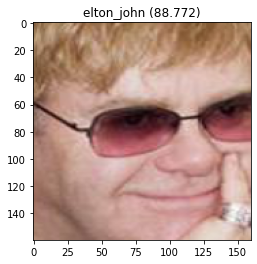

In [111]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [136]:
# for taking image input from camera

In [119]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


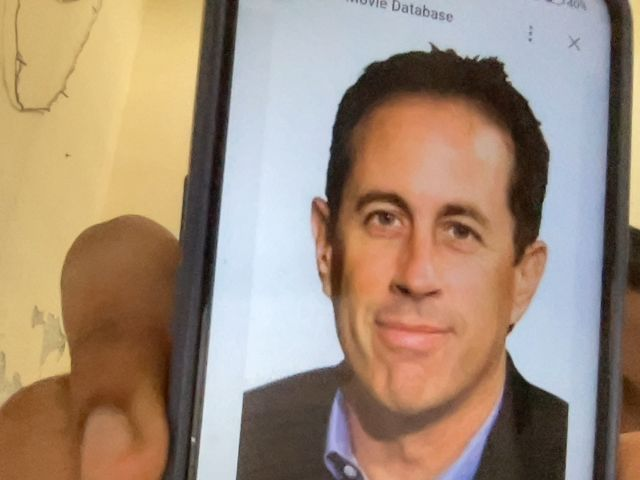

In [120]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [121]:
from PIL import Image

In [126]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

input_image = 'photo.jpg'
face = extract_face(input_image)
print('Input_Test_Image_shape', face.shape)

model = FaceNet()

embd_test = list()

embd_test = get_embedding(model, face)

print('Input_test_embeddings_shape', embd_test.shape)

data = np.load(r'5-celebrity-faces-embeddings.npz')
embd_img, flabels = data['arr_0'], data['arr_1']

print('Loaded data: Train_image_embedding_shape = {} , Test_image_embedding_shape = {}'.format(embd_img.shape, embd_test.shape))

in_encode = Normalizer(norm = 'l2')
embd_img = in_encode.fit_transform(embd_img)
k = np.array(embd_test)
k = k.reshape(1, -1)
embd_test = k
embd_test = in_encode.transform(embd_test)

model2 = SVC(kernel = 'linear', probability = True)
model2.fit(embd_img, flabels)
predictions = model2.predict(embd_test)
probability = model2.predict_proba(embd_test)
confidence = np.max(probability)

1/1 [==============================] - 0s 151ms/step
Input_Test_Image_shape (160, 160, 3)
1/1 [==============================] - 2s 2s/step
Input_test_embeddings_shape (512,)
Loaded data: Train_image_embedding_shape = (93, 512) , Test_image_embedding_shape = (512,)


predicted_label ['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling']
predicted_prob [ 2.69769537  4.37275934 87.37872135  2.49489988  3.05592406]
87.37872134681137
Confidence : 0.8737872134681137


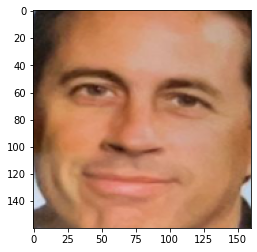

In [135]:
plt.imshow(face)

predicted_label = out_encoder.inverse_transform([0,1,2,3,4])
print('predicted_label', predicted_label)
print('predicted_prob', probability[0]*100)
print(max(probability[0]*100))
print('Confidence :', confidence)